# Keypoint Detection using YOLO v7 #

TODOS  

* make graph of different models' AP
* visualize difference
* change pose skeleton to actual deformity skeleton or just leave them out and write deformity 
* visualize deformity classifier and make average deformation inference
* port to video
* write report
* hand in report on 6th in the evening

## Instructions on running this notebook ##

* clone repository including the necessary, adapted YOLOv7 main and pose branches, as well as the most recent dataset
* change paths to your own environment's
* run the pip install and conda install commands for the necessary versions of certain packages that work best in combination with each other
* 

In [8]:
# ensure the following packages are present in their respective versions

!pip install seaborn
!pip install split-folders
!pip install --force-reinstall opencv-python-headless==4.1.2.30
!pip install --force-reinstall numpy==1.22.0
!pip install onnxruntime==1.10.0
!pip install wandb
#!conda install -c conda-forge ipywidgets

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 21.8 MB 4.1 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 96.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.22.0
    Uninstalling numpy-1.22.0:
      Successfully uninstalled numpy-1.22.0
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.1.2.30
    Uninstalling opencv-python-headless-4.1.2.30:
      Successfully uninstalled opencv-python-headless-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.6.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.3 which is incompatible

In [9]:
import sys
import torch
import torchvision
import cv2
import yaml
import matplotlib.pyplot as plt
from torchvision   import transforms
import numpy as np
import os
sys.path.append("FishVision")
%matplotlib inline

!nvidia-smi

# if error with ipywidgets: use "conda install -c conda-forge ipywidgets" in terminal

Sun Jun  4 22:39:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.86.01    Driver Version: 515.86.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM3...  On   | 00000000:39:00.0 Off |                    0 |
| N/A   47C    P0    66W / 312W |   2536MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

/home/tanjan/FishVision/yolov7_nokpt
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', no_trace=False, nosave=False, project='runs/detect', save_conf=False, save_txt=False, source='inference/images/horses.jpg', update=False, view_img=False, weights=['yolov7.pt'])
YOLOR 🚀 v0.1-122-g3b41c2c torch 1.12.0a0+bd13bc6 CUDA:0 (Tesla V100-SXM3-32GB, 32510.6875MB)

Fusing layers... 
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
RepConv.fuse_repvgg_block
Model Summary: 306 layers, 36905341 parameters, 6652669 gradients
 Convert model to Traced-model... 
 traced_script_module saved! 
 model is traced! 

/opt/conda/lib/python3.8/site-packages/torch/functional.py:599: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:2299.)
  return _VF.meshgrid(tensors, **kwargs) 

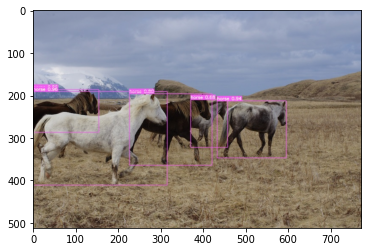

In [10]:
# YOLO v7 setup

%cd /home/tanjan/FishVision/yolov7_nokpt

from utils.datasets import letterbox
from utils.general import non_max_suppression_kpt
from utils.plots import output_to_keypoint, plot_skeleton_kpts
import numpy

'''
# testing YOLO setup with inference
!python detect.py --weights yolov7.pt --source inference/images/horses.jpg --img 640

im = plt.imread('/home/tanjan/FishVision/yolov7_nokpt/runs/detect/exp5/horses.jpg')
implot = plt.imshow(im)
plt.show()
'''

## Testing for human keypoint detection with pretrained model and weights ##

In [11]:
# initialize for CUDA with pretrained pose estimation weights for human model test

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

if model: 
    print("Model ready")

Model ready


In [12]:
testimage = 'Pontatal-86klein.jpg'

image = cv2.imread(testimage)
image = letterbox(image, 960, stride=64, auto=True)[0]
image_ = image.copy()
image = transforms.ToTensor()(image)
image = torch.tensor(np.array([image.numpy()]))

if torch.cuda.is_available():
    image = image.half().to(device)   
output, _ = model(image)

print("Ready")

Ready


Output ready


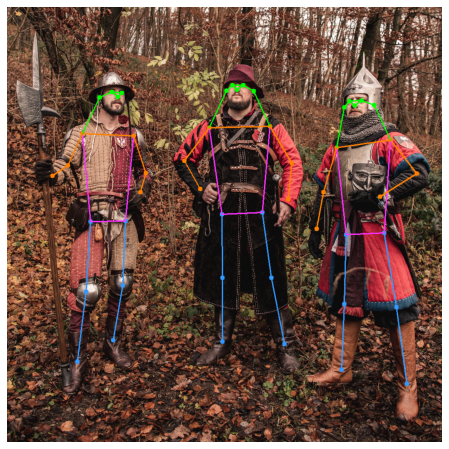

In [13]:
output = non_max_suppression_kpt(output, 0.25, 0.65, nc=model.yaml['nc'], nkpt=model.yaml['nkpt'], kpt_label=True)
if output:
    print("Output ready")
with torch.no_grad():
    output = output_to_keypoint(output)
nimg = image[0].permute(1, 2, 0) * 255
nimg = nimg.cpu().numpy().astype(np.uint8)
nimg = cv2.cvtColor(nimg, cv2.COLOR_RGB2BGR)
for idx in range(output.shape[0]):
    plot_skeleton_kpts(nimg, output[idx, 7:].T, 3)
    
plt.figure(figsize=(8,8))
plt.axis('off')
plt.imshow(nimg)
plt.show()

## Application for Fish Keypoint Detection ##

* ensure that keypoints are in YOLOv7 annotation format
* split data into test/train
* keep weights of yolov7-w6-pose.pt and test on fish to gain new weights from best trained model
* infer using unseen salmon images of various types
* no need to augment data manually, as YOLOv7 uses the mosaic technique to internally augment images in 8 extra ways per image

### Visualization and choice of keypoints in 17-keypoint model ###

* YOLO v7 can accomodate a maximum of 17 keypoints due to its adaptation for 17 keypoints of the human body in pose estimation, set during training with the COCO dataset
* of 20 given keypoints (1-20), the least useful will be removed for training the model
* keypoints 17, 19 and 20 will be removed as they're not necessary for any specific measurements

### Deformity Detection ###

Currently, the detected keypoints are connected within the model as if they're part of the human body. To remedy that and to see if the ratios between correctly assigned keypoints are viewed as desirable (see deformity types), distances between the following keypoints will be calculated and collected within a separate dataset to analyze statistically.

* jaw deformity of keypoint ratios between KP 1 to 4: distances of 1-4, 1-2, 2-3
* length vs. height ratio (slim fish): 1 -> 18 vs 9/10/11 in a triangle in which the midpoint of 9 and 10 is used as the 

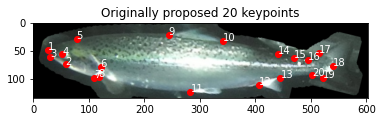

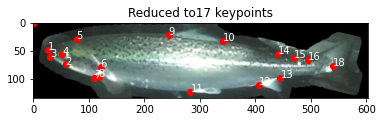

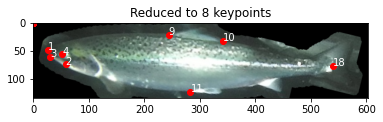

In [14]:
# example image for keypoint visualization 

im = plt.imread('/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/images/fish/2022-04-11-00-01-10_right.jpg_7.png')
kpts_20 = [(27, 48), (58, 74), (30, 61), (52, 56), (78, 28), (121, 79), (110, 98), (118, 97), (244, 21), (341, 32), (283, 124), (407, 111),
           (445, 98), (441, 55), (470, 62), (494, 66), (515, 53), (540, 77), (521, 99), (502, 94)]
kpts_20 = list(zip(*kpts_20))

implot = plt.imshow(im)
plt.title("Originally proposed 20 keypoints")
plt.plot(kpts_20[0],kpts_20[1], 'or')
for x,y in zip(kpts_20[0],kpts_20[1]):

    label = (kpts_20[0].index(x)+1)

    plt.annotate(label, 
                 (x,y), 
                 textcoords="offset points",
                 xytext=(0,0), 
                 color='white',
                 ha='left')
plt.show()


# 17 keypoints
# realistically, YOLOv7 will take extra points only as zero values from the annotations, so non-used values are zeroed out

kpts_17 = [(27, 48), (58, 74), (30, 61), (52, 56), (78, 28), (121, 79), (110, 98), (118, 97), (244, 21), (341, 32), (283, 124), (407, 111),
           (445, 98), (441, 55), (470, 62), (494, 66), (0, 0), (540, 77), (0, 0), (0, 0)]
kpts_17 = list(zip(*kpts_17))

implot = plt.imshow(im)
plt.title("Reduced to17 keypoints")
plt.plot(kpts_17[0],kpts_17[1], 'or')
for x,y in zip(kpts_17[0],kpts_17[1]):
    if x!=0 and y!=0:
        label = (kpts_17[0].index(x)+1)
        plt.annotate(label, # this is the text
                 (x,y),
                 textcoords="offset points", 
                 xytext=(0,0),
                 color='white',
                 ha='left')
plt.show()

# 8 keypoints

kpts_17 = [(27, 48), (58, 74), (30, 61), (52, 56), (0, 0), (0, 0), (0, 0), (0, 0), (244, 21), (341, 32), (283, 124), (0, 0),
           (0, 0), (0, 0), (0, 0), (0, 0), (0, 0), (540, 77), (0, 0), (0, 0)]
kpts_17 = list(zip(*kpts_17))

implot = plt.imshow(im)
plt.title("Reduced to 8 keypoints")
plt.plot(kpts_17[0],kpts_17[1], 'or')
for x,y in zip(kpts_17[0],kpts_17[1]):
    if x!=0 and y!=0:
        label = (kpts_17[0].index(x)+1)
        plt.annotate(label,
                 (x,y),
                 textcoords="offset points",
                 xytext=(0,0),
                 color='white',
                 ha='left')
plt.show()

In [15]:
# function definition for COCO JSON to YOLOv7 keypoint format annotaion conversion
# forked and adapted to keypoint formats from JSON2YOLO by Ultralytics at https://github.com/ultralytics/JSON2YOLO/

import splitfolders
import json
import itertools
from pathlib import Path
from tqdm import tqdm

def make_dirs(dir, version=0):
    # version: labels/images folders, inside each are test/train/valid
    if version==0:
            # Create folders
        dir = Path(dir)
        for p in dir, dir / 'labels', dir / 'images':
            p.mkdir(parents=True, exist_ok=True)  # make dir
        return dir

'''
reordering of directories for YOLOv7 directory format
'''
def reorder_dirs(root):
    # move data up a folder
    for basedir in listdir(root): # /images and /test
        for subdir in listdir(join(root, basedir)): # /test, /train and /val
            for subsubdir in listdir(join(root, basedir, subdir)): # class directory (fish/anno)
                for filename in listdir(join(root, basedir, subdir, subsubdir)): # move all files up into parent folder
                    move(join(root, basedir, subdir, subsubdir, filename), join(root, basedir, subdir, filename))
                rmdir(join(root, basedir, subdir, subsubdir))
    
    yolo_dirs = ['test', 'train', 'val']
    for _dir in yolo_dirs:
        print(_dir)
        _dir = os.path.join(root, _dir)
        if not os.path.exists(_dir):
            os.makedirs(_dir)
        if not os.path.exists(join(root, _dir, 'images')):
            os.makedirs(join(root, _dir, 'images'))
        if not os.path.exists(join(root, _dir, 'labels')):
            os.makedirs(join(root, _dir, 'labels'))
    
    basedir = os.path.join(root, r'images')
    for subdir in listdir(basedir):
        for filename in listdir(join(root, basedir, subdir)): # move all files up into
            move(join(root, basedir, subdir, filename), join(root, subdir, 'images', filename))
        rmdir(join(root, basedir, subdir))
    rmdir(join(root, basedir))

    basedir = os.path.join(root, r'labels')
    for subdir in listdir(basedir):
        for filename in listdir(join(root, basedir, subdir)): # move all files up into
            move(join(root, basedir, subdir, filename), join(root, subdir, 'labels', filename))
        rmdir(join(root, basedir, subdir))    
    rmdir(join(root, basedir))

def coco91_to_coco80_class():  # converts 80-index (val2014) to 91-index (paper)
    # https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/
    # a = np.loadtxt('data/coco.names', dtype='str', delimiter='\n')
    # b = np.loadtxt('data/coco_paper.names', dtype='str', delimiter='\n')
    # x1 = [list(a[i] == b).index(True) + 1 for i in range(80)]  # darknet to coco
    # x2 = [list(b[i] == a).index(True) if any(b[i] == a) else None for i in range(91)]  # coco to darknet
    x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, None, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, None, 24, 25, None,
         None, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, None, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
         51, 52, 53, 54, 55, 56, 57, 58, 59, None, 60, None, None, 61, None, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72,
         None, 73, 74, 75, 76, 77, 78, 79, None]
    return x
        
# converter function
def convert_coco_json(json_dir, n_kpts, omit=None, use_segments=False, cls91to80=False):
    save_dir = json_dir
    coco80 = coco91_to_coco80_class()

    # Import json
    for json_file in sorted(Path(json_dir).resolve().glob('*.json')):
        print("enter loop")
        fn = Path(save_dir) / 'labels' / json_file.stem.replace('instances_', '')  # folder name
        
        with open(json_file) as f:
            data = json.load(f)

        # Create image dict
        images = {'%g' % x['id']: x for x in data['images']}

        # Write labels file
        for x in tqdm(data['annotations'], desc=f'Annotations {json_file}'):
            img = images['%g' % x['image_id']]
            h, w, f = img['height'], img['width'], img['file_name']

            # The COCO box format is [top left x, top left y, width, height]
            box = np.array(x['bbox'], dtype=np.float64)
            
            if box[0]==0 and box[1]==0:
                # move bbox coordinates by 1 px in each inward direction to avoid faulty normalization
                box[0] += 1
                box[1] += 1
                box[2] -= 1
                box[3] -= 1

            box[:2] += box[2:] / 2  # xy top-left corner to center
            box[[0, 2]] /= w  # normalize x
            box[[1, 3]] /= h  # normalize y
            
            #extract keypoints from JSON
            keypoints = np.array(x['keypoints'], dtype=np.float64)
            #print("Original KP", keypoints)
            
            if omit:
                # omit chosen keypoints
                idx_to_omit = []
                for kp in omit:
                    kp -= 1
                    idx_to_omit.append(kp*3)
                    idx_to_omit.append(kp*3+1)
                    idx_to_omit.append(kp*3+2)
                keypoints = np.delete(keypoints, idx_to_omit)
                       
            #normalize keypoints in each triplet of x, y and occlusion flag (occlusion flag not converted)
            keypoints[0::3] /= w # normalize x
            keypoints[1::3] /= h # normalize y
            print(keypoints)
            
            # will append three 0.000000 float values after the used keypoints and result in different indexing, but is due to data format YOLOv7 takes
            if n_kpts < 17:
                fillers = 17-n_kpts
                values = [0.000000, 0.000000, 0.000000]
                for fr in range(fillers):
                    keypoints = np.append(keypoints, values, axis=None)
            #print("Normalized KP after filling up with 0.000000", keypoints)
            
            box_key = np.append(box, keypoints)
            for val in box_key:
                if val == 1:
                    val = 1.0
           
            # Segments
            if use_segments:
                segments = [j for i in x['segmentation'] for j in i]  # all segments concatenated
                s = (np.array(segments).reshape(-1, 2) / np.array([w, h])).reshape(-1).tolist()

            # Write
            if box[2] > 0 and box[3] > 0:  # if w > 0 and h > 0
                cls = coco80[x['category_id'] - 1] if cls91to80 else x['category_id'] - 1  # class
                line = cls, *(s if use_segments else box_key)  # cls, box/keypoints or segments
                with open((fn / f).with_suffix('.txt'), 'a') as file:
                    file.write(('%g ' * len(line)).rstrip() % line + '\n')
                    
        
print("Functions ready")

Functions ready


In [65]:
# ONLY COMPUTE IF NECESSARY
'''
keypoint conversion from COCO to YOLO v7 format
converting the ultralytics JSON2YOLO converter at https://github.com/ultralytics/JSON2YOLO for additional keypoint data
format: class, x_center, y_center, width, height, kpt1_x, kpt1_y, visibility_1, ..., kptn_x, kptn_y, visibility_n
'''

source_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct'

# define keypoints for omission to fit the 17-keypoint format used by COCO trained YOLOv7
# WARNING: keypoints start counting at 1, conversion will be made internally, do NOT adjust for index 0
omitted_kp = [17, 19, 20]

convert_coco_json(source_dir, 17, omitted_kp)

enter loop


Annotations /home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/annotations.json: 100%|██████████| 468/468 [00:00<00:00, 5348.81it/s]


In [58]:
# ONLY COMPUTE IF NECESSARY

# Split with a ratio of .8 : .1 : .1 train:test:val with a reproducible seed for both labels and images created within last step

from os.path import join
from os import listdir, rmdir
from shutil import move

working_dir = '/home/tanjan/FishVision'

root = os.path.join(working_dir, r'data_17')
if not os.path.exists(root):
    os.makedirs(root)

label_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/labels'
img_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/images'
label_target_dir = '/home/tanjan/FishVision/data_17/labels'
img_target_dir = '/home/tanjan/FishVision/data_17/images'

splitfolders.ratio(label_dir, output=label_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
splitfolders.ratio(img_dir, output=img_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

reorder_dirs(root)

'\n# move data to right folders for YOLOv7 to read\nfor basedir in listdir(root):\n    for subdir in listdir(join(root, basedir)):\n        for subsubdir in listdir(join(root, basedir, subdir)):\n            for filename in listdir(join(root, basedir, subdir, subsubdir)):\n                move(join(root, basedir, subdir, subsubdir, filename), join(root, basedir, subdir, filename))\n            rmdir(join(root, basedir, subdir, subsubdir))\n'

### Model training - 17 Keypoints ###

In [16]:
# initialize for CUDA with pretrained pose estimation weights

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

In [ ]:
# custom model training in simple CLI fashion using yolov7 pose branch without virtual torch container
%cd /home/tanjan/FishVision/yolov7

!python train.py --data data/fish_17kpts.yaml --workers 8 --epochs 50 --cfg cfg/yolov7-w6-pose.yaml --weights yolov7-w6-pose.pt --batch-size 32 --img 640 --kpt-label --sync-bn --device 0 --name yolov7-fish-seventeen --hyp data/hyp.pose.yaml
# add "-m torch.distributed.launch --nproc_per_node 8 --master_port 9527" after train.py if running distributed torch containers

### Model testing - 17 keypoints ###

In [4]:
# testing 

!python test.py --data data/fish_kpts.yaml --conf 0.001 --iou 0.65 --kpt-label --weights yolov7-w6-pose.pt --batch 32 --img 640 --device 0 --name yolov7-fish-seventeen
# -m torch.distributed.launch --nproc_per_node 8 --master_port 9527

Namespace(augment=False, batch_size=32, conf_thres=0.001, data='data/fish_kpts.yaml', device='0', dump_img=False, exist_ok=False, flip_test=False, img_size=640, iou_thres=0.65, kpt_label=True, name='yolov7-fish-test', project='runs/test', save_conf=False, save_hybrid=False, save_json=False, save_json_kpt=False, save_txt=False, save_txt_tidl=False, single_cls=False, task='val', tidl_load=False, verbose=False, weights=['yolov7-w6-pose.pt'])
YOLOv5 � cad7aca torch 1.12.0a0+bd13bc6 CUDA:0 (Tesla V100-SXM3-32GB, 32510.6875MB)

Fusing layers... 
Model Summary: 494 layers, 80178356 parameters, 80178356 gradients
/opt/conda/lib/python3.8/site-packages/torch/_tensor.py:1140: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make 

### Inference testing with best models ###

The current best models to test with will be drawn from the respective directory of the run with the best mAP.

In [33]:
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/4.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/salmosalar01.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/salmosalar02.jpg" --kpt-label

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_bin=False, save_conf=False, save_crop=False, save_txt=False, save_txt_tidl=False, source='inf_img/4.jpg', update=False, view_img=False, weights=['runs/train/yolov7-fish27/weights/best.pt'])
YOLOv5 � cad7aca torch 1.12.0a0+bd13bc6 CUDA:0 (Tesla V100-SXM3-32GB, 32510.6875MB)

Fusing layers... 
Model Summary: 494 layers, 80178356 parameters, 0 gradients
image 1/1 /home/tanjan/FishVision/yolov7/inf_img/4.jpg: tensor(0.82373, device='cuda:0')
640x640 1 fish, Done. (0.025s)
Results saved to runs/detect/exp12
Done. (0.063s)
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosav

In [33]:
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/4.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/salmosalar01.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/salmosalar02.jpg" --kpt-label

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_bin=False, save_conf=False, save_crop=False, save_txt=False, save_txt_tidl=False, source='inf_img/4.jpg', update=False, view_img=False, weights=['runs/train/yolov7-fish27/weights/best.pt'])
YOLOv5 � cad7aca torch 1.12.0a0+bd13bc6 CUDA:0 (Tesla V100-SXM3-32GB, 32510.6875MB)

Fusing layers... 
Model Summary: 494 layers, 80178356 parameters, 0 gradients
image 1/1 /home/tanjan/FishVision/yolov7/inf_img/4.jpg: tensor(0.82373, device='cuda:0')
640x640 1 fish, Done. (0.025s)
Results saved to runs/detect/exp12
Done. (0.063s)
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosav

In [33]:
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/4.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/salmosalar01.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/salmosalar02.jpg" --kpt-label

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_bin=False, save_conf=False, save_crop=False, save_txt=False, save_txt_tidl=False, source='inf_img/4.jpg', update=False, view_img=False, weights=['runs/train/yolov7-fish27/weights/best.pt'])
YOLOv5 � cad7aca torch 1.12.0a0+bd13bc6 CUDA:0 (Tesla V100-SXM3-32GB, 32510.6875MB)

Fusing layers... 
Model Summary: 494 layers, 80178356 parameters, 0 gradients
image 1/1 /home/tanjan/FishVision/yolov7/inf_img/4.jpg: tensor(0.82373, device='cuda:0')
640x640 1 fish, Done. (0.025s)
Results saved to runs/detect/exp12
Done. (0.063s)
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosav

In [33]:
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/4.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/salmosalar01.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish27/weights/best.pt --source "inf_img/salmosalar02.jpg" --kpt-label

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_bin=False, save_conf=False, save_crop=False, save_txt=False, save_txt_tidl=False, source='inf_img/4.jpg', update=False, view_img=False, weights=['runs/train/yolov7-fish27/weights/best.pt'])
YOLOv5 � cad7aca torch 1.12.0a0+bd13bc6 CUDA:0 (Tesla V100-SXM3-32GB, 32510.6875MB)

Fusing layers... 
Model Summary: 494 layers, 80178356 parameters, 0 gradients
image 1/1 /home/tanjan/FishVision/yolov7/inf_img/4.jpg: tensor(0.82373, device='cuda:0')
640x640 1 fish, Done. (0.025s)
Results saved to runs/detect/exp12
Done. (0.063s)
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosav

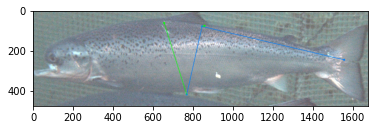

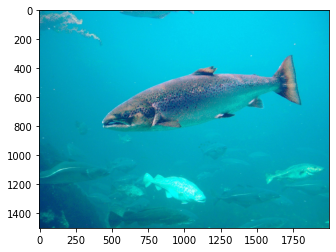

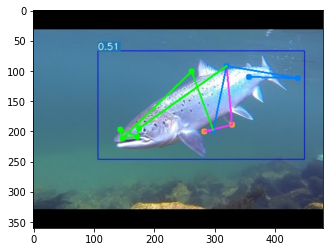

In [36]:
im = plt.imread('/home/tanjan/FishVision/yolov7/runs/detect/exp12/4.jpg')
implot = plt.imshow(im)
plt.show()

im = plt.imread('/home/tanjan/FishVision/yolov7/runs/detect/exp13/salmosalar01.jpg')
implot = plt.imshow(im)
plt.show()

im = plt.imread('/home/tanjan/FishVision/yolov7/runs/detect/exp14/salmosalar02.jpg')
implot = plt.imshow(im)
plt.show()

### Results of YOLOv7 model training and validation with 17 keypoints ###

* confusion matrix of single keypoints
* curves from wandb
* plot some infered fish keypoints

## Adaptation for 8 Keypoints ##

To achieve the best possible result with minimal effort for the given goal (deformity detection), a variant with 8 keypoints was chosen to only use those that are used for deformity detection

* 1-4 for jaw deformity
* 18 for length measurement from 1 to 18
* 9-10 for slim fish syndrome detection

In [ ]:
# ONLY COMPUTE IF NECESSARY

# create new annotations and images set in /data_8
'''
keypoint conversion from COCO to YOLO v7 format
converting the ultralytics JSON2YOLO converter at https://github.com/ultralytics/JSON2YOLO for additional keypoint data
format: class, x_center, y_center, width, height, kpt1_x, kpt1_y, visibility_1, ..., kptn_x, kptn_y, visibility_n
'''
source_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct'

# define keypoints for omission to fit the 17-keypoint format used by COCO trained YOLOv7
# WARNING: keypoints start counting at 1, conversion will be made internally, do NOT adjust for index 0
omitted_kp = [5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 19, 20]

convert_coco_json(source_dir, 8, omitted_kp)

# Split with a ratio of .8 : .1 : .1 train:test:val with a reproducible seed for both labels and images created within last step

working_dir = '/home/tanjan/FishVision'

root = os.path.join(working_dir, r'data_8')
if not os.path.exists(root):
    os.makedirs(root)

label_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/labels'
img_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/images'
label_target_dir = '/home/tanjan/FishVision/data_8/labels'
img_target_dir = '/home/tanjan/FishVision/data_8/images'

splitfolders.ratio(label_dir, output=label_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
splitfolders.ratio(img_dir, output=img_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

reorder_dirs(root)

In [ ]:
# ONLY COMPUTE IF NECESSARY

# create new annotations and images set in /data_8
'''
keypoint conversion from COCO to YOLO v7 format
converting the ultralytics JSON2YOLO converter at https://github.com/ultralytics/JSON2YOLO for additional keypoint data
format: class, x_center, y_center, width, height, kpt1_x, kpt1_y, visibility_1, ..., kptn_x, kptn_y, visibility_n
'''
source_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct'

# define keypoints for omission to fit the 17-keypoint format used by COCO trained YOLOv7
# WARNING: keypoints start counting at 1, conversion will be made internally, do NOT adjust for index 0
omitted_kp = [5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 19, 20]

convert_coco_json(source_dir, 8, omitted_kp)

# Split with a ratio of .8 : .1 : .1 train:test:val with a reproducible seed for both labels and images created within last step

working_dir = '/home/tanjan/FishVision'

root = os.path.join(working_dir, r'data_8')
if not os.path.exists(root):
    os.makedirs(root)

label_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/labels'
img_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/images'
label_target_dir = '/home/tanjan/FishVision/data_8/labels'
img_target_dir = '/home/tanjan/FishVision/data_8/images'

splitfolders.ratio(label_dir, output=label_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
splitfolders.ratio(img_dir, output=img_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

reorder_dirs(root)

In [ ]:
# ONLY COMPUTE IF NECESSARY

# create new annotations and images set in /data_8
'''
keypoint conversion from COCO to YOLO v7 format
converting the ultralytics JSON2YOLO converter at https://github.com/ultralytics/JSON2YOLO for additional keypoint data
format: class, x_center, y_center, width, height, kpt1_x, kpt1_y, visibility_1, ..., kptn_x, kptn_y, visibility_n
'''
source_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct'

# define keypoints for omission to fit the 17-keypoint format used by COCO trained YOLOv7
# WARNING: keypoints start counting at 1, conversion will be made internally, do NOT adjust for index 0
omitted_kp = [5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 19, 20]

convert_coco_json(source_dir, 8, omitted_kp)

# Split with a ratio of .8 : .1 : .1 train:test:val with a reproducible seed for both labels and images created within last step

working_dir = '/home/tanjan/FishVision'

root = os.path.join(working_dir, r'data_8')
if not os.path.exists(root):
    os.makedirs(root)

label_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/labels'
img_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/images'
label_target_dir = '/home/tanjan/FishVision/data_8/labels'
img_target_dir = '/home/tanjan/FishVision/data_8/images'

splitfolders.ratio(label_dir, output=label_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
splitfolders.ratio(img_dir, output=img_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

reorder_dirs(root)

In [ ]:
# ONLY COMPUTE IF NECESSARY

# create new annotations and images set in /data_8
'''
keypoint conversion from COCO to YOLO v7 format
converting the ultralytics JSON2YOLO converter at https://github.com/ultralytics/JSON2YOLO for additional keypoint data
format: class, x_center, y_center, width, height, kpt1_x, kpt1_y, visibility_1, ..., kptn_x, kptn_y, visibility_n
'''
source_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct'

# define keypoints for omission to fit the 17-keypoint format used by COCO trained YOLOv7
# WARNING: keypoints start counting at 1, conversion will be made internally, do NOT adjust for index 0
omitted_kp = [5, 6, 7, 8, 12, 13, 14, 15, 16, 17, 19, 20]

convert_coco_json(source_dir, 8, omitted_kp)

# Split with a ratio of .8 : .1 : .1 train:test:val with a reproducible seed for both labels and images created within last step

working_dir = '/home/tanjan/FishVision'

root = os.path.join(working_dir, r'data_8')
if not os.path.exists(root):
    os.makedirs(root)

label_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/labels'
img_dir = '/home/tanjan/FishVision/Smordalen_M1_2022-04-11_biomass_correct/images'
label_target_dir = '/home/tanjan/FishVision/data_8/labels'
img_target_dir = '/home/tanjan/FishVision/data_8/images'

splitfolders.ratio(label_dir, output=label_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)
splitfolders.ratio(img_dir, output=img_target_dir, seed=1337, ratio=(.8, .1, .1), group_prefix=None, move=False)

reorder_dirs(root)

### Model training - 8 keypoints ###

In [ ]:
# initialize for CUDA with pretrained pose estimation weights

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
weigths = torch.load('yolov7-w6-pose.pt', map_location=device)
model = weigths['model']
_ = model.float().eval()

if torch.cuda.is_available():
    model.half().to(device)

# custom model training in simple CLI fashion using yolov7 pose branch without virtual torch container
%cd /home/tanjan/FishVision/yolov7

!python train.py --data data/fish_8kpts.yaml --workers 8 --epochs 200 --cfg cfg/yolov7-w6-pose.yaml --weights yolov7-w6-pose.pt --batch-size 32 --img 640 --kpt-label --sync-bn --device 0 --name yolov7-fish-eight --hyp data/hyp.pose.yaml
# add "-m torch.distributed.launch --nproc_per_node 8 --master_port 9527" after train.py if running distributed torch containers

In [37]:
!python detect.py --weights runs/train/yolov7-fish-eight/weights/best.pt --source "inf_img/4.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish-eight/weights/best.pt --source "inf_img/salmosalar01.jpg" --kpt-label
!python detect.py --weights runs/train/yolov7-fish-eight/weights/best.pt --source "inf_img/salmosalar02.jpg" --kpt-label

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', nosave=False, project='runs/detect', save_bin=False, save_conf=False, save_crop=False, save_txt=False, save_txt_tidl=False, source='inf_img/4.jpg', update=False, view_img=False, weights=['runs/train/yolov7-fish-eight/weights/best.pt'])
YOLOv5 � cad7aca torch 1.12.0a0+bd13bc6 CUDA:0 (Tesla V100-SXM3-32GB, 32510.6875MB)

Fusing layers... 
Model Summary: 494 layers, 80178356 parameters, 0 gradients
image 1/1 /home/tanjan/FishVision/yolov7/inf_img/4.jpg: tensor(0.85596, device='cuda:0')
640x640 1 fish, Done. (0.026s)
Results saved to runs/detect/exp15
Done. (0.062s)
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, hide_conf=False, hide_labels=False, img_size=640, iou_thres=0.45, kpt_label=True, line_thickness=3, name='exp', n

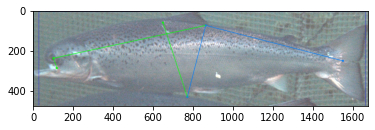

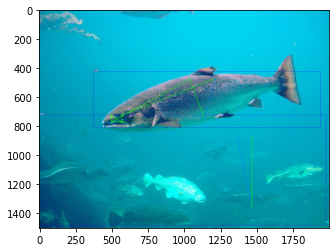

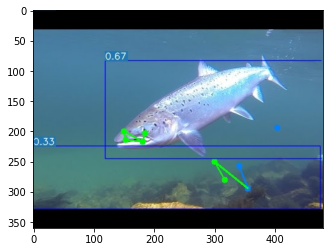

In [38]:
im = plt.imread('/home/tanjan/FishVision/yolov7/runs/detect/exp15/4.jpg')
implot = plt.imshow(im)
plt.show()

im = plt.imread('/home/tanjan/FishVision/yolov7/runs/detect/exp16/salmosalar01.jpg')
implot = plt.imshow(im)
plt.show()

im = plt.imread('/home/tanjan/FishVision/yolov7/runs/detect/exp17/salmosalar02.jpg')
implot = plt.imshow(im)
plt.show()

## Statistical Analysis of Body Ratios for Deformity Detection ##

To detect deformities, statistical analysis over distance measures and ratios must be undergone using healthy fish samples 
E.g. the length from nose to caudal fin will repesent fish length and will make a distance ratio with the width of the fish from keypoint 9 to 11. If the fish is below a certain ratio of width by length, it will be considered deformed due to
For this purpose, the 

* 